In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
options = pd.read_excel('SP500 Option Prices.xlsx', sheet_name='Sheet1')
options.head()

,Strike,Bid price,Mid price,Ask price
0,2400,1633.2,1644.70,1656.2
1,2450,1584.9,1595.95,1607.0
2,2500,1535.8,1547.00,1558.2
3,2550,1486.6,1497.60,1508.6
4,2600,1437.5,1448.70,1459.9


In [4]:
new_data = {'Strike': 0, 'Bid price': 4026.12, 'Mid price': 4026.12, 'Ask price': 4026.12}
options.loc[-1] = new_data

In [5]:
options.sort_index(inplace=True)
options.head()

,Strike,Bid price,Mid price,Ask price
-1,0,4026.12,4026.12,4026.12
0,2400,1633.20,1644.70,1656.20
1,2450,1584.90,1595.95,1607.00
2,2500,1535.80,1547.00,1558.20
3,2550,1486.60,1497.60,1508.60


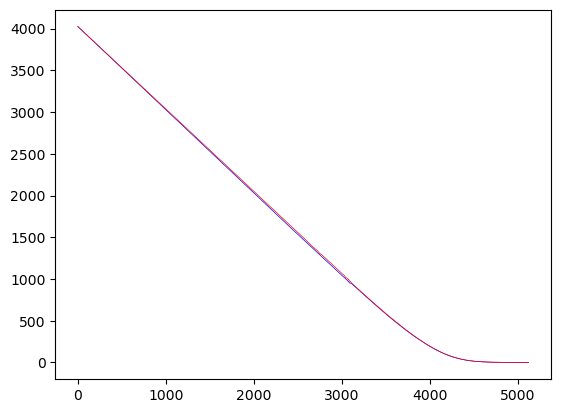

In [6]:
plt.plot(options.loc[:, "Strike"], options.loc[:, "Bid price"], color='blue', label='Bid', linewidth=0.5)
plt.plot(options.loc[:, "Strike"], options.loc[:, "Ask price"], color='red', label='Ask', linewidth=0.5)

# Consider bid-ask spread

In [7]:
r=4.175*0.01*(30-25+31+31+17)/365

# For the arbitrage in the case with bid-ask spread, we need to find a set of C(K) that satisfy the following conditions:
CK = [4026.12]
slope = []
bound = -1/(1 + r)
temp_slope = bound
flag = False
for i in range(0, len(options) - 1):
    temp = CK[-1] + temp_slope * (options['Strike'][i] - options['Strike'][i - 1])
    while temp < options['Bid price'][i]:
        temp_slope += 0.000006
        if temp_slope > 0:
            flag = True
            print("slope is positive")
            print("Out of bound")
            break
        temp = CK[-1] + temp_slope * (options['Strike'][i] - options['Strike'][i - 1])
    if flag or temp > options['Ask price'][i]:
        print(str(temp) + '>' + str(options['Ask price'][i]))
        print("Out of bound")
        break
    print(i)
    CK.append(temp)
    print(temp)
    slope.append(temp_slope)

print("Finish")

0
1648.960271690904
1
1599.4361106844644
2
1549.911949678025
3
1500.3877886715854
4
1450.863627665146
5
1401.3394666587064
6
1351.815305652267
7
1327.0532251490472
8
1302.2911446458274
9
1277.5290641426077
10
1252.766983639388
11
1228.0049031361682
12
1203.2428226329484
13
1178.4807421297287
14
1153.718661626509
15
1128.9565811232892
16
1104.1945006200694
17
1079.4324201168497
18
1054.67033961363
19
1029.9082591104102
20
1005.1461786071904
21
995.2413464059025
22
985.3365142046146
23
980.3840981039706
24
975.4316820033266
25
965.5268498020387
26
955.6220176007507
27
948.3000053994415
28
940.9779931981323
29
937.3169870974776
30
933.655980996823
926.3339687955138>925.1
Out of bound
Finish


In [8]:
# Find arbitrage strategy.

import cvxpy as cp
import numpy as np

n = len(options)
x_a = cp.Variable(n)
x_b = cp.Variable(n)


K = options.loc[:, "Strike"].values

K_i = K[:, None]
K_j = K[None, :] 

L = np.maximum(K_j - K_i, 0)

c_a = options.loc[:, "Ask price"].values
c_b = options.loc[:, "Bid price"].values

objective = cp.Minimize(cp.sum(cp.multiply(c_a, x_a) - cp.multiply(c_b, x_b)))

constraints = [L.T @ (x_a - x_b) >= 0, x_a >= 0, x_b >= 0, x_a <= 1, x_b <= 1]

problem = cp.Problem(objective, constraints)
problem.solve()

print("Optimal value:", problem.value)
print("Optimal x_a:", x_a.value)
print("Optimal x_b:", x_b.value)
 

(CVXPY) Dec 08 10:27:58 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: 找不到指定的模块。')
Optimal value: -0.18571428309261157
Optimal x_a: [4.99955184e-01 3.53870311e-13 3.43010508e-13 3.22590294e-13
 3.27846989e-13 3.09004783e-13 6.17327483e-13 3.04973246e-13
 2.68105581e-13 5.64676872e-13 2.63797190e-13 2.94307208e-13
 2.56041033e-13 2.80041797e-13 2.57616564e-13 2.79226063e-13
 2.54018237e-13 2.81852093e-13 2.63423614e-13 2.95063489e-13
 2.62044060e-13 5.49889540e-13 2.54144450e-13 2.54276698e-13
 5.80127253e-13 2.61265704e-13 5.71139313e-13 2.94982618e-13
 8.83284662e-13 9.80905682e-13 9.00753818e-13 9.00515946e-13
 9.82165209e-13 9.32307238e-13 9.39606971e-13 1.00755393e-12
 1.01498431e-12 9.36796833e-13 1.04617290e-12 1.03931736e-12
 9.74177816e-13 1.00387207e-12 9.90057128e-13 1.11053255e-12
 1.16164758e-12 1.03222803e-12 1.16136875e-12 1.18892375e-12
 1.10502073e-12 1.10300593e-12 1.10338345e-12 1.14743545e-12
 1.1579593

# Not consider bid-ask spread

In [16]:
# As the mid price is in the middle of bid-ask spreads, we are easy to construct arbitrage strategy than the case with bid-ask spread.
n = len(options) + 1
x = cp.Variable(n)

K = options.loc[:, "Strike"].values

K_i = K[:, None]
K_j = K[None, :] 

L = np.maximum(K_j - K_i, 0)
risk_free = (1 + r)*np.ones((1, n - 1))
L = np.concatenate((L, risk_free), axis=0)

p = options.loc[:, "Mid price"].values
p = np.append(p, 1)

objective = cp.Minimize(cp.sum(cp.multiply(p, x)))

constraints = [x.T @ L >= 0, x <= 1, x >= -1]

problem = cp.Problem(objective, constraints)
problem.solve()

print("Optimal value:", problem.value)
print("Optimal x:", x.value)

Optimal value: -49.66610136640696
Optimal x: [-4.20669955e-04  9.99999999e-01 -4.99369057e-01 -9.99999998e-01
  4.99789788e-01 -9.99999998e-01  1.00000000e+00  4.99999925e-01
 -9.99999999e-01  1.00000000e+00 -9.99999997e-01  9.99999998e-01
 -9.99999999e-01  9.99999993e-01 -9.99999997e-01  9.99999991e-01
 -9.99999999e-01  8.00000015e-01 -5.99999998e-01  9.99999998e-01
 -9.99999992e-01  1.00000000e+00 -9.99999999e-01 -9.99999999e-01
  1.00000000e+00 -3.00000010e-01  1.00000000e+00  9.99999999e-01
 -9.99999997e-01  9.99999998e-01 -9.99999996e-01 -9.99999996e-01
  9.99999997e-01 -9.99999995e-01 -9.99999996e-01  9.99999993e-01
  9.99999996e-01 -9.99999998e-01  9.99999761e-01  9.50000276e-01
 -9.99999998e-01 -9.99999997e-01 -9.99999997e-01  9.99999998e-01
  9.99999998e-01 -9.99999997e-01  9.99999995e-01  9.99999998e-01
  4.39999931e-01 -9.99999993e-01 -9.99999987e-01 -2.89999999e-01
 -9.99999980e-01  9.99999993e-01  9.99999998e-01 -9.99999996e-01
  9.99999998e-01 -9.99999997e-01  9.99999998e